I try to solve two problems in this project. First is to predict the severity of the crime type in the future and second is to predict high crime rate district on the whole dataset.
I use the data from City of Chicago Crime Dataset https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2. I only use dat from year 2020 to 2022 here in consideration of the large volume and also the representativeness of future after COVID.

In [1]:
# Data Exploration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in criminal data and remove irrelevant/not meaningfull attributes for this project
crime_data_2020 = pd.read_csv('Final Data/Crimes_-_2020.csv')
crime_data_2021 = pd.read_csv('Final Data/Crimes_-_2021.csv')
crime_data_2022 = pd.read_csv('Final Data/Crimes_-_2022.csv')
# because the data file is so large and the data decades ago is not really representative and also consider the impact of COVID, I'll only use data from year 2020 to present in this project

In [3]:
crime_data=pd.concat([crime_data_2020,crime_data_2021,crime_data_2022])
crime_data=crime_data[['Date','Block','Primary Type','Description','Location Description','District','Latitude','Longitude']]
crime_data.head()

,Date,Block,Primary Type,Description,Location Description,District,Latitude,Longitude
0,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,THEFT,$500 AND UNDER,STREET,16,41.952052,-87.754660
1,03/18/2020 02:03:00 AM,039XX W JACKSON BLVD,MOTOR VEHICLE THEFT,AUTOMOBILE,APARTMENT,11,41.877110,-87.723990
2,03/18/2020 08:50:00 AM,023XX N KEELER AVE,ASSAULT,SIMPLE,RESIDENCE,25,41.923369,-87.731634
3,03/18/2020 01:00:00 PM,047XX W MONROE ST,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER (SPECIFY),11,41.879264,-87.743971
4,03/18/2020 05:35:00 PM,003XX S CICERO AVE,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,15,41.876128,-87.745112


In [4]:
crime_data.shape

(634827, 8)

In [5]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634827 entries, 0 to 214893
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  634827 non-null  object 
 1   Block                 634827 non-null  object 
 2   Primary Type          634827 non-null  object 
 3   Description           634827 non-null  object 
 4   Location Description  632083 non-null  object 
 5   District              634827 non-null  int64  
 6   Latitude              624770 non-null  float64
 7   Longitude             624770 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 43.6+ MB


In [6]:
# Drop rows with 'nan' because we have plenty of data so we just choose to drop useless rows
crime_data.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
crime_data=crime_data.dropna()

In [7]:
# Make a copy of crime data for analyzing time later
crimes=crime_data.copy()

In [8]:
# Create datetime index of times that crimes happen
crime_data['Datetime'] = pd.to_datetime(crime_data['Date'])
crime_data = crime_data.set_index('Datetime')
crime_data = crime_data.drop(['Date'], axis=1)
crime_data.head()

,Block,Primary Type,Description,Location Description,District,Latitude,Longitude
Datetime,,,,,,,
2020-03-17 21:30:00,039XX N LECLAIRE AVE,THEFT,$500 AND UNDER,STREET,16,41.952052,-87.754660
2020-03-18 02:03:00,039XX W JACKSON BLVD,MOTOR VEHICLE THEFT,AUTOMOBILE,APARTMENT,11,41.877110,-87.723990
2020-03-18 08:50:00,023XX N KEELER AVE,ASSAULT,SIMPLE,RESIDENCE,25,41.923369,-87.731634
2020-03-18 13:00:00,047XX W MONROE ST,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER (SPECIFY),11,41.879264,-87.743971
2020-03-18 17:35:00,003XX S CICERO AVE,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,15,41.876128,-87.745112


In [9]:
# Arrange the data according to the datetime
crime_data=crime_data.sort_index()
crime_data.head()

,Block,Primary Type,Description,Location Description,District,Latitude,Longitude
Datetime,,,,,,,
2020-01-01,044XX S GREENWOOD AVE,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,APARTMENT,2,41.814133,-87.599358
2020-01-01,082XX S MARYLAND AVE,BURGLARY,FORCIBLE ENTRY,RESIDENCE,6,41.745354,-87.603799
2020-01-01,089XX S BURLEY AVE,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,4,41.733266,-87.545734
2020-01-01,063XX S DR MARTIN LUTHER KING JR DR,CRIMINAL SEXUAL ASSAULT,ATTEMPT NON-AGGRAVATED,APARTMENT,3,41.779120,-87.615599
2020-01-01,007XX W 61ST ST,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,7,41.783407,-87.643487


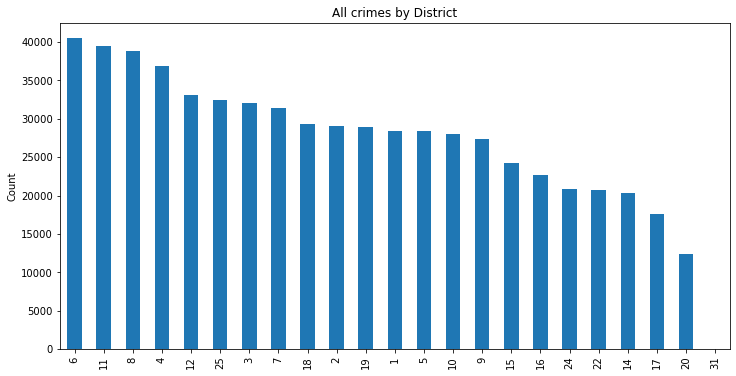

In [10]:
# Chicago crimes reported by district -- number indicated Chicago police districts
crime_data['District'].value_counts().plot.bar(figsize=(12,6))

plt.ylabel('Count')
plt.title('All crimes by District')
plt.show()
# 6th police district (Gresham) claims the most crime events; 20th police district (Lincoln) claims the least crime events

In [11]:
# I encounter a problem here because Chicago doesn't have a 31st district listed in its Police Department website. Also, it doesn't show many counts of crimes in this district, I will just drop rows with 31st district
crime_data = crime_data.drop(crime_data[crime_data.District == 31].index)
crime_data.head()

,Block,Primary Type,Description,Location Description,District,Latitude,Longitude
Datetime,,,,,,,
2020-01-01,044XX S GREENWOOD AVE,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,APARTMENT,2,41.814133,-87.599358
2020-01-01,082XX S MARYLAND AVE,BURGLARY,FORCIBLE ENTRY,RESIDENCE,6,41.745354,-87.603799
2020-01-01,089XX S BURLEY AVE,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,4,41.733266,-87.545734
2020-01-01,063XX S DR MARTIN LUTHER KING JR DR,CRIMINAL SEXUAL ASSAULT,ATTEMPT NON-AGGRAVATED,APARTMENT,3,41.779120,-87.615599
2020-01-01,007XX W 61ST ST,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,7,41.783407,-87.643487


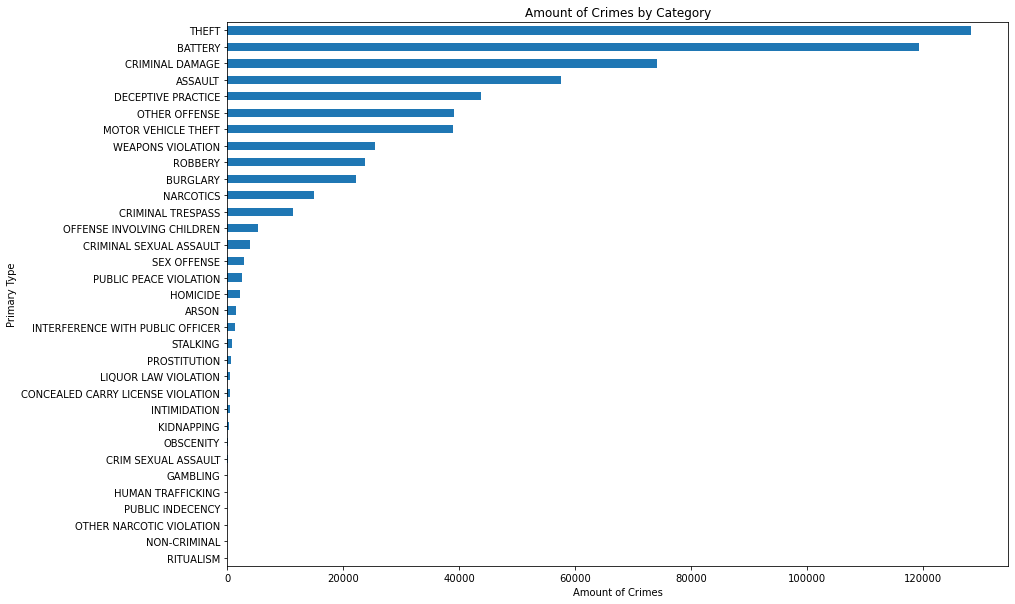

In [12]:
# Plot Bar Chart visualize Crime Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Category')
plt.ylabel('Crime Category')
plt.xlabel('Amount of Crimes')

crime_data.groupby([crime_data['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()
# Theft is the most common type of criminal activity

In [13]:
# Display all unique crime types
crime_type = crime_data['Primary Type'].unique()
crime_type

array(['OFFENSE INVOLVING CHILDREN', 'BURGLARY',
       'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT', 'THEFT',
       'BATTERY', 'DECEPTIVE PRACTICE', 'SEX OFFENSE', 'CRIMINAL DAMAGE',
       'OTHER OFFENSE', 'ASSAULT', 'WEAPONS VIOLATION', 'ROBBERY',
       'MOTOR VEHICLE THEFT', 'NARCOTICS', 'PUBLIC PEACE VIOLATION',
       'CRIMINAL TRESPASS', 'LIQUOR LAW VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'KIDNAPPING',
       'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE', 'STALKING',
       'ARSON', 'INTIMIDATION', 'OTHER NARCOTIC VIOLATION', 'GAMBLING',
       'PROSTITUTION', 'OBSCENITY', 'PUBLIC INDECENCY',
       'HUMAN TRAFFICKING', 'NON-CRIMINAL', 'RITUALISM'], dtype=object)

In [14]:
#Encode target labels into categorical variables:
crime_data['Primary Type'] = pd.factorize(crime_data["Primary Type"])[0] 
crime_data['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [15]:
# Convert Categorical Attributes to Numerical
crime_data['Block'] = pd.factorize(crime_data["Block"])[0]
crime_data['Location Description'] = pd.factorize(crime_data["Location Description"])[0]
crime_data['Description'] = pd.factorize(crime_data["Description"])[0]
crime_data.head(5)

,Block,Primary Type,Description,Location Description,District,Latitude,Longitude
Datetime,,,,,,,
2020-01-01,0,0,0,0,2,41.814133,-87.599358
2020-01-01,1,1,1,1,6,41.745354,-87.603799
2020-01-01,2,0,0,1,4,41.733266,-87.545734
2020-01-01,3,2,2,0,3,41.779120,-87.615599
2020-01-01,4,2,3,1,7,41.783407,-87.643487


In [16]:
#Correlation with output variable
cor = crime_data.corr()
cor_target = abs(cor['Primary Type'])
#Select highly correlated features
relevant_features = cor_target[cor_target>0.01]
relevant_features
# Besides the description of crime activities, we find that the location (including location type, district, detailed spot) is highly correlated with crime behaviors.

Primary Type            1.000000
Description             0.381244
Location Description    0.012438
District                0.047620
Latitude                0.058798
Longitude               0.019512
Name: Primary Type, dtype: float64

In [17]:
# Let's have a look at the second-highest feature "Location Type"
locationgb=crimes.groupby(['Location Description'])['Location Description'].value_counts()/len(crimes)*100
locationgb.sort_values(ascending=False, inplace=True)
locationgb
# The probability that the crime happened on the street is the highest.

Location Description                    Location Description                  
STREET                                  STREET                                    26.139331
APARTMENT                               APARTMENT                                 19.176135
RESIDENCE                               RESIDENCE                                 15.434258
SIDEWALK                                SIDEWALK                                   5.814308
PARKING LOT / GARAGE (NON RESIDENTIAL)  PARKING LOT / GARAGE (NON RESIDENTIAL)     3.099091
                                                                                    ...    
PUBLIC GRAMMAR SCHOOL                   PUBLIC GRAMMAR SCHOOL                      0.000161
RIVER BANK                              RIVER BANK                                 0.000161
RAILROAD PROPERTY                       RAILROAD PROPERTY                          0.000161
CHA LOBBY                               CHA LOBBY                                  0.000161
T

Text(0, 0.5, 'Occurrence rate (%)')

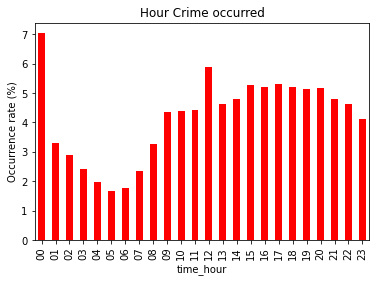

In [18]:
# Let's find out the relationship between crime behaviors and different time periods in a day
from datetime import datetime
format = '%m/%d/%Y %I:%M:%S %p'
crimes["time_hour"]=crimes.Date.apply(lambda row: datetime.strptime(row, format).strftime("%H"))
timegb=crimes.groupby(['time_hour'])["time_hour"].count()/len(crimes)*100
timegb.plot(kind='bar',title="Hour Crime occurred", color = 'red')
plt.ylabel('Occurrence rate (%)')
# We can see that the crime is concentrated mostly at noon, afternoon and midnight 12. Early morning crimes are relatively less likely to occur.

Text(0, 0.5, 'Occurrence rate (%)')

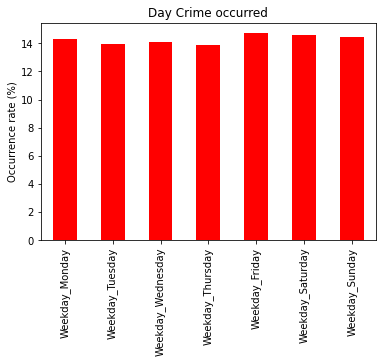

In [19]:
# I also want to check the relationship between crimes happening and the day in a week
crimes["Weekday"]=crimes.Date.apply(lambda row: datetime.strptime(row, format).strftime("%A"))
crimes=pd.get_dummies(crimes,columns=["Weekday"])
weekday=crimes[["Weekday_Monday","Weekday_Tuesday","Weekday_Wednesday","Weekday_Thursday","Weekday_Friday","Weekday_Saturday","Weekday_Sunday"]].sum()/len(crimes)*100

weekday.plot(kind='bar',title="Day Crime occurred",color='red')
plt.ylabel('Occurrence rate (%)')
# The plot returns similar results for each day in a week, which means we don't really need to care week day difference when predicting

Text(0, 0.5, 'Occurrence rate (%)')

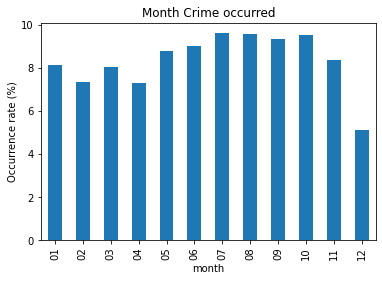

In [20]:
# Show crime occurence rate in different months
crimes["month"]=crimes.Date.apply(lambda row: datetime.strptime(row, format).strftime("%m"))
month_group=crimes.groupby(['month'])['month'].count()/len(crimes)*100
month_group.plot(kind='bar',title="Month Crime occurred")
plt.ylabel('Occurrence rate (%)')
# We can see a crime rates sharp drop in December, which hopefully will also show in the prediction results.

First, I want to predict Chicago crime severity

In [21]:
# Create target variable. Crime type is divided into multiple categories according to FBI.
# Violent crimes: arson, assault, battery, homicide, robbery, crim sexual assault, criminal damage, criminal trespass.
# Creating a binary target(IndexCrime) if the record is a violent crime or not.
crimes0=crimes.copy()
severe_crime_list=["ARSON", "ASSAULT", "BATTERY", "CRIM SEXUAL ASSAULT", "CRIMINAL DAMAGE", "CRIMINAL TRESPASS", "HOMICIDE", "ROBBERY"]
crimes0["severe"]=np.where(crimes0['Primary Type'].isin(severe_crime_list), 1, 0)
crimes0.head(5)

,Date,Block,Primary Type,Description,Location Description,District,Latitude,Longitude,time_hour,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,month,severe
0,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,THEFT,$500 AND UNDER,STREET,16,41.952052,-87.754660,21,0,0,0,0,0,1,0,03,0
1,03/18/2020 02:03:00 AM,039XX W JACKSON BLVD,MOTOR VEHICLE THEFT,AUTOMOBILE,APARTMENT,11,41.877110,-87.723990,02,0,0,0,0,0,0,1,03,0
2,03/18/2020 08:50:00 AM,023XX N KEELER AVE,ASSAULT,SIMPLE,RESIDENCE,25,41.923369,-87.731634,08,0,0,0,0,0,0,1,03,1
3,03/18/2020 01:00:00 PM,047XX W MONROE ST,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,OTHER (SPECIFY),11,41.879264,-87.743971,13,0,0,0,0,0,0,1,03,0
4,03/18/2020 05:35:00 PM,003XX S CICERO AVE,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,15,41.876128,-87.745112,17,0,0,0,0,0,0,1,03,0


In [22]:
pos=crimes[crimes0['severe']==1]
neg=crimes[crimes0['severe']==0]
percent_severe=float(len(pos))/len(crimes)
percent_non_severe=float(len(neg))/len(crimes)
print (percent_severe, percent_non_severe)

0.46601520714678074 0.5339847928532192


In [23]:
from sklearn.model_selection import train_test_split
X=crimes0.drop('severe',axis=1).drop('Date',axis=1)
y=crimes0['severe']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, train_size=0.7)

In [26]:
train,test = train_test_split(range(crimes0.shape[0]), train_size=0.7)
mask=np.ones(crimes0.shape[0], dtype='int')
mask[train]=1
mask[test]=0
mask=(mask==1)

In [27]:
#Let's make a dictionary storing confusion matrix for all the algorithms, so that we can have some comparison
confusion_dict={}
confusion_dict["Baseline_model"]=np.asarray([[len(neg),0],[len(pos),0]])
#Also create a dictionary to store all the models
model_dict={}
#The following dict will store the accuracy for training set
accuracy_dict={}
#The following dict will store the accuracy for test set
accuracy_dict1={}
train_not_severe_percent=1-float(sum(crimes0["severe"].values[mask]))/len(crimes0["severe"].values[mask])
test_not_severe_percent=1-float(sum(crimes0["severe"].values[~mask]))/len(crimes0["severe"].values[~mask])
print (train_not_severe_percent, test_not_severe_percent) 
accuracy_dict["Baseline_model"]=train_not_severe_percent
accuracy_dict1["Baseline_model"]=test_not_severe_percent

0.5334506597892255 0.5352310995229708


In [28]:
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import OneHotEncoder
encoder = make_column_transformer((OneHotEncoder(), [ 'Block','Primary Type','Description','Location Description']),
                                  remainder = 'passthrough',
                                  verbose_feature_names_out=False)

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
forest_pipe = Pipeline([('preprocess', encoder), 
                       ('model', RandomForestClassifier(max_depth = 2))])

In [31]:
forest_pipe.fit(X_train, y_train)
print(forest_pipe.score(X_train, y_train))
print(forest_pipe.score(X_test, y_test))
# I'm not sure why I get this error for the score of test data. But based on the train score I get, we can see this model doesn't perform much better than the baseline score

0.5336319268690586


ValueError: Found unknown categories ['010XX S Claremont AVE', '054XX S Woodlawn ave', '021XX W Concord Pl', '046XX N Beacon St', '057XX N OSAGE AVE', '032XX N Hoyne Ave', '006XX W 21ST ST', '014XX W 116TH ST', '012XX W Waveland Ave', '027XX N Clark ST', '040XX W Lake st', '049XX N kimball ave', '050XX S Lavergne Ave', '103XX S Commercial Ave', '051XX S Kimbark ave', '010XX N Winchester Ave', '102XX S TALMAN AVE', '070XX N HAMILTON AVE', '004XX N MARSHFIELD AVE', '031XX N Octavia Ave', '001XX W RIVERWALK S', '017XX N LAKE SHORE DR NB', '036XX N PANAMA AVE', '039XX W 110TH ST', '000XX E 121ST PL', '078XX W CORNELIA AVE', '009XX W Wrightwood Ave', '063XX N Kenmore Ave', '062XX S HAMILTON AVE', '028XX S LA SALLE ST', '022XX S LAKE SHORE DR E', '015XX W 109TH ST', '092XX S Blackstone Ave', '129XX S STONY ISLAND AVE', '021XX W SCHOOL ST', '027XX W DAKIN ST', '025XX W HOLLYWOOD AVE', '022XX N LAKE SHORE DR SB', '018XX N Natchez ave', '029XX S CALIFORNIA BLVD', '035XX W ALTGELD ST', '005XX S CONGRESS PLAZA DR', '057XX W WABANSIA AVE', '036XX W Leland Ave', '107XX S LONGWOOD DR', '037XX N LAKE SHORE DR SB', '012XX W EISENHOWER EXPY OB', '040XX E 107TH ST', '074XX S ST LOUIS AVE', '021XX N LAKE SHORE DR NB', '023XX W Arthur Ave', '040XX S WELLS ST', '018XX S Michigan Ave', '007XX W 46TH PL', '047XX N Sheridan Rd', '130XX S BISHOP FORD EXPY IB', '029XX W REDFIELD DR', '011XX N Cleveland Ave', '074XX W CORNELIA AVE', '050XX N Lincoln Ave', '002XX E 77th St', '033XX W Schubert Ave', '013XX W BLACKHAWK ST', '070XX N Greenview Ave', '057XX S BELL AVE', '037XX W Wrightwood Ave', '003XX W Chestnut St', '011XX E 59TH ST', '044XX W THORNDALE AVE', '017XX W 37TH ST', '017XX W 106TH ST', '025XX E 108TH ST', '045XX W CARROLL AVE', '0000X S Ashland ave', '013XX W 105TH PL', '004XX E Ohio St', '029XX E 132ND ST', '102XX S Oakley Ave', '073XX N OLEANDER AVE', '054XX S CORNELL ave', '036XX W 115TH PL', '011XX W Chestnut St', '043XX W 50TH ST', '029XX N Commonwealth Ave', '080XX S WALLACE ST', '069XX N Clark St', '037XX E 110TH ST', '031XX S WOLCOTT AVE', '0000X E IDA B WELLS DR', '004XX E Oakwood Blvd', '110XX S DOTY AVE E', '068XX S BENNETT AVE', '114XX S BELL AVE', '026XX W 31ST ST', '077XX W PETERSON AVE', '010XX W Oakdale ave', '047XX N Ravenswood ave', '043XX W NORWOOD AVE', '104XX S SEELEY AVE', '038XX W 48TH ST', '044XX W 82ND ST', '027XX W ADDISON ST', '033XX N Lincoln Ave', '041XX N PAULINA ST', '003XX S SPAULDING AVE', '017XX E 55th St', '031XX S EBERHART AVE', '045XX N Winchester Ave', '113XX S SPAULDING AVE', '030XX N Clark St', '026XX N Washtenaw Ave', '009XX S LA SALLE ST', '056XX W BELLE PLAINE AVE', '054XX N FRANCISCO AVE', '055XX N LOWELL AVE', '100XX S RACINE AVE', '007XX W CONCORD PL', '029XX W BURKHARDT DR', '005XX E WACKER DR', '044XX S MORGAN ST', '041XX N Campbell Ave', '0000X S LOWER WACKER DR', '012XX W GLADYS AVE', '018XX W Cuyler Ave', '028XX W 54TH ST', '016XX W Fullerton Ave', '017XX W Rascher Ave', '083XX S DAN RYAN EXPY OB', '069XX S HOLLETT DR', '001XX E 134TH ST', '031XX W 46TH ST', '071XX N CALDWELL AVE', '016XX E 84th St', '026XX N Greenview Ave', '054XX W GALE ST', '030XX N Sheridan Rd', '021XX W Grand Ave', '042XX W VICTORIA ST', '018XX N Monticello Ave', '042XX W 25TH PL', '031XX W Irving Park RD', '009XX N Ashland Ave', '015XX W BERTEAU AVE', '061XX S Western Ave', '046XX W WALTON ST', '013XX W 37TH ST', '009XX W Belmont Ave', '052XX W Addison St', '010XX W 99TH ST', '008XX E 99TH ST', '034XX E 103RD ST', '008XX N ALBANY AVE', '072XX W CORNELIA AVE', '014XX W Grand Ave', '026XX N Lakeview Ave', '006XX W Hubbard St', '026XX W FRANCIS PL', '007XX W Fulton Market', '084XX S ANTHONY AVE', '014XX W touhy ave', '004XX W 73RD ST', '060XX W Lawrence Ave', '028XX N LAKE SHORE DR NB', '024XX S LAKE SHORE DR W', '063XX S LAWLER AVE', '039XX N Ashland Ave', '080XX W BERWYN AVE', '014XX W Balmoral Ave', '002XX E 15TH PL', '050XX N CUMBERLAND AVE', '015XX S Albany Ave', '008XX S wells st', '031XX N Karlov Ave', '0000X W 33RD ST', '095XX S HAMILTON AVE', '088XX S KINGSTON AVE', '013XX W Argyle St', '035XX S DR MARTIN LUTHER KING JR SD', '017XX S KOSTNER AVE', '026XX E 122ND ST', '035XX N Racine Ave', '063XX S DAN RYAN LOCAL IB', '121XX S AVENUE O', '053XX S KARLOV AVE', '053XX W HUTCHINSON ST', '019XX N LEAMINGTON AVE', '034XX N SAYRE AVE', '132XX S DOTY AVE W', '066XX S CENTRAL PARK AVE', '026XX E 82ND ST', '009XX E 111TH ST', '055XX W ROOSEVELT RD', '007XX E MIDWAY PLAISANCE', '007XX W Cornelia Ave', '019XX N Lincoln ave', '031XX N Wolcott Ave', '008XX W 110TH ST', '037XX S MAY ST', '063XX N IONIA AVE', '051XX S MEADE AVE', '087XX S GREENWOOD AVE', '013XX W PERSHING RD', '038XX N Hoyne Ave', '063XX N MERRIMAC AVE', '007XX W 128TH PL', '057XX N LEONARD AVE', '079XX S HAMLIN AVE', '012XX E 70TH ST', '058XX S KILPATRICK AVE', '111XX S CHURCH ST', '028XX W MANN DR', '111XX S LOTHAIR AVE', '029XX S AVERS AVE', '011XX E 60TH ST', '020XX N LAKE SHORE DR SB', '067XX S HOYNE AVE', '005XX S PAULINA ST', '005XX E 108TH ST', '060XX N KEDZIE AVE', '007XX E 61st St', '037XX W 114TH ST', '001XX N State ST', '057XX N Ashland Ave', '069XX N sheridan rd', '075XX W CHASE AVE', '051XX N Damen Ave', '004XX E 18th dr', '003XX E WACKER SUB DR', '101XX S TALMAN AVE', '004XX S DESPLAINES ST', '0000X E Grand Ave', '029XX W Balmoral Ave', '029XX N SAYRE AVE', '002XX W OAK ST', '012XX W 37TH ST', '073XX N KEDZIE AVE', '058XX S Maryland Ave', '065XX S Ellis Ave', '007XX W 14th St', '057XX S KARLOV AVE', '026XX W Belden Ave', '004XX N Artesian Ave', '072XX W NORTH SHORE AVE', '049XX N NORMANDY AVE', '042XX W 48TH ST', '057XX S COLUMBIA DR', '079XX W IRVING PARK RD', '002XX E 85TH ST', '056XX W Division St', '026XX W 13TH PL', '018XX N Bissell St', '008XX W 64TH ST', '056XX N OSCEOLA AVE', '017XX W Belmont Ave', '011XX E 132ND ST', '061XX N BERNARD ST', '027XX N Wilton Ave', '039XX N NEENAH AVE', '012XX E 48TH ST', '038XX W 109TH PL', '023XX W 33RD ST', '073XX N MC VICKER AVE', '027XX E 82ND ST', '011XX N RUSH ST', '001XX W 96TH ST', '011XX W George St', '025XX W 119TH ST', '004XX W 93RD ST', '089XX S PRAIRIE AVE', '031XX N PAULINA ST', '046XX W 46TH ST', '105XX S DREW ST', '033XX N Seminary Ave', '006XX W Wayman St', '036XX W BARRY AVE', '038XX N Fremont St', '009XX N Leavitt St', '051XX W 49TH ST', '070XX W DEVON AVE', '028XX W SUNNYSIDE AVE', '025XX W addison st', '132XX S Carondolet Ave', '134XX S DR MARTIN LUTHER KING JR DR', '015XX N LUIS MUNOZ MARIN DR E', '044XX W ANN LURIE PL', '021XX N Elston Ave', '059XX S MC VICKER AVE', '003XX W 46TH PL', '016XX E MIDWAY PLAISANCE', '020XX W LAKE ST', '007XX S Campbell Ave', '047XX W 49TH ST', '008XX N Clark St', '024XX W Foster Ave', '027XX W Giddings St', '024XX S STEWART AVE', '077XX W ROSCOE ST', '076XX S Coles ave', '062XX N FOREST GLEN AVE', '008XX W Erie st', '077XX W DEVON AVE', '054XX S MILLARD AVE', '060XX N Sheridan Rd', '008XX S ADA ST', '013XX W Fulton ST', '037XX W 72ND ST', '055XX S Keeler Ave', '048XX N Talman Ave', '020XX E 94TH ST', '059XX N CALDWELL AVE', '051XX N LARAMIE AVE', '047XX N Kedvale Ave', '024XX N Kedzie Blvd', '079XX S OAKLEY AVE', '070XX S CENTRAL PARK AVE', '002XX W 27TH ST', '043XX N KILPATRICK AVE', '017XX W Highland Ave', '042XX S KEELER AVE', '007XX W Maxwell St', '068XX W 53RD ST', '0000X S WASHTENAW AVE', '020XX S PEORIA ST', '036XX S WESTERN BLVD', '003XX E 101ST ST', '066XX W BERWYN AVE', '005XX W 77TH ST', '007XX W 126TH ST', '019XX W 119TH ST', '083XX S KOMENSKY AVE', '066XX N OLYMPIA AVE', '001XX E 98TH ST', '034XX W 31ST ST', '007XX E MORGAN DR', '025XX S LOOMIS ST', '008XX N Rush St', '031XX W Grand Ave', '024XX W 102ND ST', '065XX N ridge blvd', '003XX W 125TH ST', '001XX E 102ND ST', '010XX W Polk st', '094XX S GREENWOOD AVE', '017XX S DAMEN AVE', '033XX S FEDERAL ST', '011XX E 76TH ST', '005XX W 63RD PL', '060XX N Winthrop Ave', '003XX E 100TH ST', '029XX W JARLATH ST', '074XX S GREENWOOD AVE', '107XX S HOYNE AVE', '059XX S DAN RYAN LOCAL OB', '063XX N KNOX AVE', '032XX W 110TH ST', '022XX W 112TH ST', '017XX W NEWPORT AVE', '057XX N Elston Ave', '053XX S MELVINA AVE', '057XX N KERCHEVAL AVE', '084XX W LAWRENCE AVE', '133XX S AVENUE L', '020XX W Pierce Ave', '005XX S LEAVITT ST', '028XX W Sunnyside Ave', '068XX S HOLLETT DR', '012XX E 49TH ST', '012XX E 81ST ST', '057XX S MERRIMAC AVE', '065XX N ALGONQUIN AVE', '030XX W 104TH ST', '067XX W WRIGHTWOOD AVE', '030XX N hamilton ave', '033XX N MEADE AVE', '048XX N MARMORA AVE', '037XX W 51ST ST', '045XX W PETERSON AVE', '071XX W FOREST PRESERVE AVE', '048XX N NAGLE AVE', '042XX N AVERS AVE', '031XX W 108TH ST', '0000X W Chestnut St', '006XX N Wolcott Ave', '090XX S HOLLAND RD', '072XX W BRYN MAWR AVE', '026XX W Chicago Ave', '0000X E Adams St', '067XX N FAIRFIELD AVE', '008XX W Windsor Ave', '029XX N Dawson Ave', '062XX N Nagle Ave', '057XX S PERRY AVE', '007XX W COURT PL', '042XX S WHIPPLE ST', '085XX S Lafayette Ave', '043XX W BERWYN AVE', '064XX N Albany Ave', '062XX S CENTRAL PARK AVE', '084XX S WHIPPLE ST', '012XX W Hubbard St', '008XX W WISCONSIN ST', '062XX S NEENAH AVE', '043XX W WELLINGTON AVE', '025XX W 72ND ST', '045XX W WILSON AVE', '056XX W 60TH ST', '0000X E Monroe St', '060XX W CORNELIA AVE', '0000X E Scott St', '004XX W 46TH PL', '054XX N Campbell Ave', '005XX W Dickens Ave', '050XX W BERWYN AVE', '008XX S LARAMIE AVE', '034XX N DRAKE AVE', '076XX W CORNELIA AVE', '050XX S LEAVITT ST', '053XX S Greenwood Ave', '098XX S Avenue J', '089XX S OAKLEY AVE', '064XX S SPAULDING AVE', '053XX W Argyle St', '013XX W Wilson Ave', '056XX S Narragansett Ave', '047XX W WALTON ST', '019XX W WASHBURNE AVE', '027XX W Augusta Blvd', '0000X N WOLCOTT AVE', '045XX S Vincennes Ave', '013XX E 55TH PL', '077XX W FARGO AVE', '034XX N Marshfield Ave', '017XX W AINSLIE ST', '047XX S KENWOOD AVE', '043XX W 57TH ST', '007XX S Plymouth Ct', '114XX S LAWNDALE AVE', '061XX S Greenwood Ave', '040XX S NORMAL AVE', '083XX S KOLMAR AVE', '035XX W cortland st', '005XX S FRANKLIN ST', '093XX S HAMILTON AVE', '016XX W Division St', '010XX S Clinton St', '033XX E 133RD ST', '116XX S ST LOUIS AVE', '042XX S LAKE SHORE DR SB', '019XX W irving park rd', '005XX W 109TH ST', '078XX W GLENLAKE AVE', '064XX S Kimbark Ave', '0000X E 98TH ST', '067XX N RICHMOND ST', '002XX W 46TH ST', '080XX S CENTRAL PARK AVE', '044XX S LAPORTE AVE', '130XX S BISHOP FORD EXPY OB', '005XX N STATE St', '037XX W 107TH ST', '047XX N CHESTER AVE', '110XX S CALIFORNIA AVE', '004XX W MONROE ST', '112XX S BELL AVE', '002XX W 48TH PL', '003XX S JENSEN BLVD', '043XX N Hermitage Ave', '018XX E 80TH ST', '022XX W Byron St', '004XX W 45TH PL', '031XX N clark st', '088XX S VINCENNES AVE', '060XX N BERNARD ST', '0000X W C17 ST', '009XX S PAULINA ST', '010XX W 101ST ST', '002XX N Pine Ave', '033XX W 85TH PL', '016XX N Dayton St', '073XX N CALIFORNIA AVE', '029XX W 103RD ST', '004XX W Roslyn Pl', '010XX S MORGAN ST', '126XX S BUTLER DR', '010XX W Cornelia Ave', '006XX W Schubert Ave', '007XX E 134TH PL', '044XX W 81ST ST', '062XX S LARAMIE AVE', '009XX W Waveland Ave', '013XX W BELLE PLAINE AVE', '018XX E MARQUETTE DR', '027XX N Clybourn Ave', '069XX W FOSTER AVE', '046XX N Clark St', '100XX S AVENUE G DR', '110XX S STONY ISLAND AVE', '026XX W Carmen ave', '012XX W Wellington Ave', '070XX S CICERO AVE', '061XX N Keeler Ave', '058XX N INDIAN RD', '009XX W 127TH ST', '045XX W HUTCHINSON AVE', '080XX W GRACE ST', '007XX W 118TH PL', '037XX N Fremont St', '003XX S LOWER WACKER DR', '033XX W 53RD ST', '041XX N Claremont Ave', '108XX S PRINCETON AVE', '019XX W WEBSTER AVE', '021XX N Oakley Ave', '073XX W PRATT AVE', '030XX E 88TH ST', '094XX S VINCENNES AVE', '019XX W 107TH ST', '032XX S FEDERAL ST', '078XX W RASCHER AVE', '036XX N MEADE AVE', '030XX W Diversey Ave', '025XX W SCHUBERT AVE', '108XX S LAWNDALE AVE', '019XX W Lawrence Ave', '111XX S ARTESIAN AVE', '044XX W HOLLYWOOD AVE', '057XX N MANNHEIM RD', '085XX W WILSON AVE', '0000X W superior st', '010XX W 54TH ST', '017XX W 102ND ST', '031XX N Karlov ave', '024XX W 82ND ST', '026XX E 106TH ST', '023XX W 94TH ST', '017XX W Ainslie st', '034XX S WABASH AVE', '012XX N campbell ave', '092XX S VINCENNES AVE', '030XX E 82ND ST', '081XX W SCHOOL ST', '019XX E 80TH ST', '034XX E 108TH ST', '017XX E 90TH ST', '088XX S CHICAGO SKYWAY OB', '031XX N Clybourn Ave', '078XX W ROSCOE ST', '017XX W 97th St', '031XX N ALBANY AVE', '008XX W 14th Pl', '063XX S ST LOUIS AVE', '013XX W 116TH ST', '061XX N LANDERS AVE', '086XX S Drexel Ave', '050XX N Sheridan RD', '002XX N Jefferson st', '020XX W 13TH ST', '072XX W BYRON ST', '010XX E 46th st', '004XX E HURON ST', '136XX S AVENUE O', '012XX W Albion Ave', '024XX W 113TH ST', '062XX W HYACINTH ST', '002XX N FIELD BLVD', '0000X E Lake St', '054XX S MOBILE AVE', '028XX W GEORGE ST', '018XX S CLINTON ST', '004XX W 44TH ST', '017XX W HASTINGS ST', '028XX W 15TH PL', '046XX N Beacon ST', '044XX N Greenview Ave', '032XX N LAKE SHORE DR SB', '025XX E 100TH ST', '017XX S HOYNE AVE', '108XX S BELL AVE', '071XX W SCHOOL ST', '000XX W 87TH ST', '044XX N California Ave', '016XX W Julian St', '055XX N PULASKI RD', '016XX N NORDICA AVE', '063XX W PALMER ST', '016XX N Harding ave', '008XX W 108TH ST', '027XX S SHIELDS AVE', '012XX W Carmen Ave', '023XX W CORNELIA AVE', '014XX W CORTLAND ST', '029XX W SEIPP ST', '060XX S MULLIGAN AVE', '052XX W 51ST ST', '031XX N Clark St', '037XX W 104TH ST', '057XX N KARLOV AVE', '058XX W ARDMORE AVE', '013XX E 76th st', '014XX W Lexington St', '008XX W 40TH ST', '002XX S WINCHESTER AVE', '049XX W 44TH PL', '061XX S HOMAN AVE', '002XX N LOWER COLUMBUS DR', '027XX W 36TH PL', '013XX E 76Th St', '006XX W 97TH ST', '013XX W Fletcher St', '025XX N Bosworth Ave', '006XX W 88TH ST', '043XX W 44TH ST', '065XX N CHICORA AVE', '126XX S AVENUE O', '017XX W Cullerton St', '100XX S Normal Ave', '023XX W RIVER LOFT CT', '023XX N Lincoln Park West', '013XX E 54th St', '069XX W WAVELAND AVE', '027XX W 48TH ST', '003XX W 99TH ST', '065XX W CORNELIA AVE', '100XX S HAMILTON AVE', '008XX W 35TH PL', '005XX E 138TH ST', '006XX W 105TH ST', '032XX N Elston Ave', '036XX S OAKLEY AVE', '034XX N Elaine PL', '098XX S HARPER AVE', '051XX S LAVERGNE AVE', '022XX W Ainslie ST', '010XX S SACRAMENTO BLVD', '033XX N NATOMA AVE', '007XX W 52ND ST', '022XX W 57TH ST', '044XX N Leavitt St', '043XX W GRACE ST', '006XX S HERMITAGE AVE', '115XX S HOMAN AVE', '021XX N Halsted St', '055XX S MARYLAND AVE', '045XX W SCHOOL ST', '042XX N Tripp Ave', '006XX W Wellington Ave', '032XX N OCTAVIA AVE', '001XX W hubbard st', '035XX S Lowe Ave', '008XX W Chicago Ave', '007XX S LOCKWOOD AVE', '006XX E ILLINOIS ST', '024XX N DAMEN AVE', '017XX S PULASKI RD', '022XX N Washtenaw Ave', '004XX W Division St', '070XX N OAKLEY AVE', '013XX N LAKE SHORE DR NB', '043XX W 85TH ST', '007XX W EASTMAN ST', '026XX W 86TH ST', '057XX N Jersey Ave', '032XX E 85TH ST', '058XX N EAST CIRCLE AVE', '027XX E 88TH ST', '0000X W Ontario St', '031XX W SCHOOL ST', '131XX S GREENWOOD AVE', '074XX W TOUHY AVE', '039XX S RACINE AVE', '018XX N KINGSBURY ST', '039XX S FEDERAL ST', '007XX E 120TH ST', '026XX W Pershing Rd', '040XX W Melrose st', '074XX W ROSCOE ST', '122XX S JUSTINE ST', '064XX S NATCHEZ AVE', '039XX S EMERALD AVE', '014XX W LE MOYNE ST', '043XX W 27TH ST', '037XX W SCHRAEDER DR', '004XX E GARFIELD BLVD', '023XX W OAKDALE AVE', '0000X N DESPLAINES ST', '067XX S CHICAGO SKYWAY IB', '060XX S MOODY AVE', '013XX W Randolph St', '062XX N KILPATRICK AVE', '007XX W Couch PL', '004XX W 63RD PL', '062XX N GREENVIEW AVE', '025XX N KEDZIE SD', '033XX N Oakley ave', '013XX W 113TH PL', '002XX N MOZART ST', '028XX W 45TH ST', '013XX W Elmdale Ave', '051XX W HOMER ST', '0000X E Jackson Blvd', '017XX S MUSEUM CAMPUS DR', '045XX W ROSCOE ST', '005XX W Quincy St', '014XX W Lunt Ave', '074XX N Hoyne Ave', '054XX S Kimbark Ave', '057XX S Kenneth Ave', '008XX E 105TH ST', '006XX W Cornelia Ave', '052XX N OKETO AVE', '048XX S FEDERAL ST', '028XX W 77TH ST', '011XX W Roscoe st', '064XX N LE MAI AVE', '042XX N Central Park Ave', '063XX N Wayne Ave', '0000X N WOOD ST', '060XX N kenmore ave', '060XX S KIMBARK AVE', '041XX W 85TH ST', '059XX N WEST CIRCLE AVE', '066XX N OSHKOSH AVE', '029XX W 86TH PL', '029XX W JEROME ST', '027XX W FARGO AVE', '040XX W 81ST PL', '077XX S Avalon Ave', '041XX S KEELER AVE', '023XX E 92ND PL', '026XX W chicago ave', '006XX W Wayman st', '033XX W 114TH ST', '060XX S Richmond St', '021XX W 18th St', '014XX W 122ND ST', '026XX E 104TH ST', '054XX W EDMUNDS ST', '027XX S WELLS ST', '055XX N MEADE AVE', '032XX N ANCHOR DR', '022XX W Wilson Ave', '059XX S AUSTIN AVE', '030XX W 79TH ST', '090XX S WESTERN AVE', '101XX S CENTRAL PARK AVE', '114XX S AVENUE G', '047XX S Dorchester Ave', '014XX E 64TH ST', '049XX S AVERS AVE', '035XX N KARLOV AVE', '008XX W EISENHOWER EXPY OB', '019XX N lincoln ave', '015XX W Hubbard St', '005XX E KENSINGTON AVE', '007XX W 34TH ST', '024XX W BRADLEY PL', '043XX N MANNHEIM RD', '019XX W 117TH ST', '027XX W ALTGELD ST', '107XX S AVERS AVE', '010XX E 78TH ST', '046XX W 55TH ST', '001XX S SPAULDING AVE', '057XX W POTOMAC AVE', '022XX W PETERSON AVE', '005XX E 85TH ST', '063XX W Huntington st', '029XX W MANN DR', '047XX S DAN RYAN LOCAL IB', '130XX S RHODES AVE', '024XX W Lunt Ave', '109XX S ST LOUIS AVE', '041XX W Oakdale ave', '052XX W DEVON AVE', '025XX S Michigan Ave', '016XX N LAKE SHORE DR SB', '039XX S LOWE AVE', '071XX N MERRIMAC AVE', '011XX S FAIRFIELD AVE', '019XX S Michigan Ave', '038XX W 115TH ST', '048XX S ST LOUIS AVE', '063XX N Broadway', '088XX S CHICAGO SKYWAY IB', '063XX N CALDWELL AVE', '050XX S VINCENNES AVE', '037XX N Troy St', '086XX S KILBOURN AVE', '065XX W BYRON ST', '027XX W Montrose Ave', '090XX S PRAIRIE AVE', '059XX S RUSSELL DR', '037XX N Central Park Ave', '019XX W KINZIE ST', '126XX S DOTY AVE E', '004XX E BEST DR', '013XX N NORTH PARK AVE', '022XX W 87TH ST', '018XX N HUMBOLDT SD', '062XX N WINCHESTER AVE', '022XX W BLOOMINGDALE AVE', '025XX W Winnemac Ave', '000XX N KEDZIE AVE', '015XX E 81ST ST', '010XX S Columbus Dr', '023XX N Southport Ave', '009XX W HOLLYWOOD AVE', '005XX W 128TH PL', '066XX N OCTAVIA AVE', '077XX W HOWARD ST', '119XX S ADA ST', '034XX E 112TH ST', '053XX S Harlem Ave', '063XX N LA CROSSE AVE', '051XX N OVERHILL AVE', '041XX N OAK PARK AVE', '028XX N Drake Ave', '0000X W TOOKER PL', '078XX W FOSTER AVE', '057XX N NEWCASTLE AVE', '058XX S Natchez Ave', '130XX S BUFFALO AVE', '037XX N HAMLIN AVE', '052XX W SUNNYSIDE AVE', '007XX W 97TH ST', '060XX W GEORGE ST', '019XX N Orchard St', '036XX S LA SALLE ST', '0000X E CHICAGO RIVER', '008XX E 106TH ST', '027XX N Lincoln Ave', '029XX N OAKLEY AVE', '015XX N leavitt st', '018XX N LAKE SHORE DR SB', '022XX N RACINE AVE', '034XX N Clark St', '015XX W fargo ave', '021XX W Huron St', '018XX N Kedzie Ave', '041XX S KARLOV AVE', '045XX N Broadway', '054XX N MAGNET AVE', '0000X S DOOR 3 ST', '028XX W REDFIELD DR', '066XX N CENTRAL AVE', '009XX N DEWITT PL', '013XX S Canal St', '0000X N State st', '063XX N OLCOTT AVE', '035XX N Fremont St', '048XX N OAK PARK AVE', '042XX W 84TH ST', '042XX S DAN RYAN LOCAL OB', '135XX S FOREST AVE', '018XX W 85TH ST', '074XX W EVERELL AVE', '014XX S sacramento dr', '040XX W SCHUBERT AVE', '018XX W Augusta Blvd', '011XX E 63RD ST', '017XX E 91ST ST', '065XX W RAVEN ST', '013XX S INDIANA PKWY', '107XX S RACINE AVE', '064XX S Central Ave', '041XX S PACKERS AVE', '006XX W 25TH PL', '064XX W Irving park rd', '068XX N MINNETONKA AVE', '072XX W GRACE ST', '104XX S ST LOUIS AVE', '054XX N CANFIELD AVE', '047XX W 72ND ST', '046XX N DELPHIA AVE', '011XX W 58TH ST', '005XX N Marshfield Ave', '025XX S ARTESIAN AVE', '082XX W MONTROSE AVE', '039XX W 76TH ST', '024XX E 90TH ST', '020XX N KENNEDY EXPY OB', '021XX W Walton St', '013XX S Michigan Ave', '020XX W SCHOOL ST', '021XX E 130TH ST', '032XX W 109TH ST', '029XX N GREENVIEW AVE', '034XX W 87TH ST', '039XX N Fremont St', '042XX W 19TH ST', '012XX S Indiana Ave', '011XX W Webster Ave', '026XX N Cannon dr', '066XX S SPRINGFIELD AVE', '027XX S Sawyer Ave', '044XX W ARGYLE ST', '004XX W Surf St', '031XX W ALBION AVE', '039XX E 105TH ST', '013XX W 84TH ST', '044XX W 46TH ST', '008XX W Van Buren St', '029XX S TROY ST', '028XX W 47TH PL', '052XX N Leamington Ave', '031XX N MEADE AVE', '011XX E 75TH ST', '031XX W Fullerton Ave', '003XX E 99TH PL', '006XX E 107TH ST', '003XX W Willow St', '023XX W 101ST ST', '008XX W 63RD PKWY', '091XX S MUSKEGON AVE', '051XX W Carmen Ave', '025XX W ARDMORE AVE', '014XX W Pratt Blvd', '005XX W 82ND ST', '004XX W Huron st', '049XX N lincoln ave', '047XX W 50TH ST', '006XX E RAINEY DR', '0000X S B17 ST', '013XX W 122ND ST', '083XX S WHIPPLE ST', '072XX S PULASKI RD', '060XX S CORNELL DR', '014XX S MCCORMICK PL BUSWAY', '047XX N NARRAGANSETT AVE', '048XX N Winchester Ave', '053XX S Laflin st', '024XX N Oakley Ave', '032XX W 108TH PL', '117XX S Western Ave', '032XX N Ashland Ave', '0000X W 23RD ST', '038XX S DEARBORN ST', '014XX W Morse Ave', '083XX S LAKE SHORE DR', '008XX N wood st', '011XX W 76th St', '043XX W 53RD ST', '019XX E 82ND ST', '017XX W Morse Ave', '099XX S PULASKI RD', '075XX S ROCKWELL ST', '119XX S PEORIA ST', '060XX S DAN RYAN LOCAL IB', '134XX S BRAINARD AVE', '103XX S SPRINGFIELD AVE', '066XX S HOMAN AVE', '006XX W Grace St', '055XX S Indiana ave', '010XX W 37TH ST', '020XX N Kedzie Ave', '079XX S KILDARE AVE', '059XX N MILTIMORE AVE', '013XX E 130TH ST', '060XX S OAK PARK AVE', '034XX W BARRY AVE', '061XX W LAWRENCE AVE', '037XX W Palmer St', '021XX N LAKEWOOD AVE', '014XX W 89TH ST', '019XX S KILBOURN AVE', '026XX W 115TH ST', '008XX N Hoyne Ave', '045XX N Ashland Ave', '026XX E 85TH ST', '027XX W Lunt Ave', '041XX N Sheridan Rd', '023XX N lincoln ave', '055XX S NORDICA AVE', '022XX W 65TH ST', '012XX W CORTEZ ST', '001XX N LOOMIS ST', '071XX S Campbell Ave', '017XX N Campbell ave', '003XX N Desplaines St', '004XX S LEAMINGTON AVE', '030XX W Sherwin Ave', '062XX N HARLEM AVE', '023XX W WINONA ST', '044XX N Ravenswood Ave', '008XX N LESSING ST', '064XX W HOBART AVE', '082XX W CATHERINE AVE', '079XX S SAWYER AVE', '015XX W 118TH ST', '061XX S YALE AVE', '024XX W Chicago Ave', '013XX N Paulina St', '118XX S STONY ISLAND AVE', '037XX W GRANVILLE AVE', '038XX W Devon Ave', '098XX S WENTWORTH AVE', '015XX S PAULINA ST', '005XX W 89TH ST', '049XX N JANSSEN AVE', '003XX E 119TH PL', '050XX W 52ND ST', '059XX N LEGETT AVE', '127XX S DOTY AVE E', '011XX E 92ND ST', '033XX W OGDEN SD', '005XX W Englewood Ave', '008XX W Newport Ave', '002XX W 61ST ST', '040XX N Sheridan RD', '032XX W WAVELAND AVE', '025XX N Lakeview Ave', '058XX N KENNETH AVE', '028XX S Kenneth ave', '059XX W CARMEN AVE', '009XX W Grace St', '010XX W Argyle St', '065XX S CENTRAL PARK AVE', '059XX N AVONDALE AVE', '005XX E 103RD PL', '109XX S HOYNE AVE', '022XX W SUNNYSIDE AVE', '067XX S HAMILTON AVE', '027XX E 85TH ST', '135XX S AVENUE N', '001XX E 109TH ST', '127XX S Manistee Ave', '106XX S CENTRAL PARK AVE', '000XX N MAYFIELD AVE', '014XX W Oakdale Ave', '039XX N PLAINFIELD AVE', '055XX S University Ave', '115XX W IRVING PARK RD', '063XX W LAWRENCE AVE', '059XX W POTOMAC AVE', '002XX N Garland ct', '052XX W DICKENS AVE', '045XX S DR MARTIN LUTHER KING JR SD', '037XX N Bernard St', '063XX W GREGORY ST', '077XX S yates blvd', '048XX S WALLACE ST', '076XX W HORTENSE AVE', '010XX W 14th PL', '063XX S NASHVILLE AVE', '032XX N Lake Shore Dr', '033XX N CUMBERLAND AVE', '034XX N BELMONT HARBOR DR', '056XX W BRYN MAWR AVE', '051XX S HAMLIN AVE', '002XX W 98TH PL', '056XX N RAVENSWOOD AVE', '062XX W STRONG ST', '029XX W Belden Ave', '007XX W 91ST ST', '066XX S DORCHESTER AVE', '031XX N broadway', '043XX N central ave', '037XX W CARMEN AVE', '053XX N Lincoln Ave', '025XX W Harrison St', '001XX E 124TH PL', '037XX W 114TH PL', '029XX W GRANVILLE AVE', '026XX S SENOUR AVE', '014XX W Lexington st', '038XX W 87TH ST', '038XX N MENARD AVE', '014XX E 60TH ST', '018XX E 103RD ST', '080XX W FOSTER AVE', '001XX W Lake St', '049XX S WELLS ST', '065XX S HOMAN AVE', '003XX E Randolph st', '017XX S CALIFORNIA BLVD', '044XX N Wolcott Ave', '038XX W ROSEMONT AVE', '033XX S LA SALLE ST', '053XX W Giddings st', '048XX S HAMLIN AVE', '020XX W 37TH ST', '113XX W IRVING PARK RD', '033XX W WALTON ST', '030XX W 103RD ST', '096XX S THROOP ST', '123XX S BURLEY AVE', '003XX W 38TH ST', '023XX W Wilson Ave', '070XX N TAHOMA AVE', '042XX W 45TH ST', '025XX E 99TH ST', '043XX S DR MARTIN LUTHER KING JR SD', '066XX S LAWNDALE AVE', '084XX W HIGGINS RD', '019XX E 88TH ST', '073XX W CHASE AVE', '024XX E 83RD ST', '004XX E Randolph St', '018XX S KILBOURN AVE', '041XX S PEORIA ST', '070XX W CORTLAND ST', '113XX S DOTY AVE E', '121XX S PEORIA ST', '012XX W Lake St', '004XX W 57TH ST', '027XX N Lawndale Ave', '022XX N Monticello Ave', '130XX S BURLEY AVE', '057XX N OZANAM AVE', '062XX S NEW ENGLAND AVE', '042XX S WOLCOTT AVE', '005XX E 104TH ST', '020XX W 115TH ST', '031XX W LUIS MUNOZ MARIN DR S', '110XX S ALBANY AVE', '110XX S WASHTENAW AVE', '001XX W 24TH ST', '041XX N Major Ave', '036XX E 134TH ST', '027XX W 19TH ST', '046XX N FOREST VIEW AVE', '002XX E 38TH ST', '019XX E 77TH ST', '014XX W Polk ST', '012XX W 48TH ST', '020XX W 58TH ST', '042XX W 49TH ST', '005XX E 101ST ST', '024XX W 77TH ST', '033XX W Monroe St', '113XX S BELL AVE', '053XX N LARNED AVE', '047XX W 53RD ST', '070XX N Glenwood Ave', '053XX S MASSASOIT AVE', '112XX S SAWYER AVE', '081XX S FRANCISCO AVE', '038XX W 105TH ST', '046XX W ARTHINGTON ST', '040XX N TRIPP AVE', '057XX S MAJOR AVE', '025XX W Diversey Ave', '112XX S MARSHFIELD AVE', '036XX N Hoyne Ave', '024XX N Western Ave', '026XX W 45TH ST', '008XX W 106TH ST', '121XX S DOTY AVE W', '003XX E 24TH PL', '053XX S Hyde Park Blvd', '071XX W MEDILL AVE', '051XX S NATOMA AVE', '069XX W BELDEN AVE', '009XX S Ashland Ave', '022XX W LUNT AVE', '055XX N CANFIELD AVE', '032XX W THORNDALE AVE', '083XX W BALMORAL AVE', '061XX N ORIOLE AVE', '039XX N LAKE SHORE DR SB', '094XX S CLYDE AVE', '022XX N KEDZIE SD', '021XX E MARQUETTE DR', '084XX S Vincennes Ave', '030XX W 109TH ST', '017XX N North Park Ave', '0000X E NORTH AVE', '078XX S KEDVALE AVE', '027XX W 109TH ST', '045XX S LAKE SHORE DR NB', '043XX N LAMON AVE', '029XX N HONORE ST', '020XX N Burling St', '023XX W 65TH ST', '062XX W WELLINGTON AVE', '032XX N MOBILE AVE', '019XX W CARROLL AVE', '059XX W PETERSON AVE', '020XX W WELLINGTON AVE', '052XX W ARDMORE AVE', '109XX S Western Ave', '0000X E Oak St', '005XX W IRVING PARK DR', '034XX W 48TH PL', '082XX S KOSTNER AVE', '052XX N WOLCOTT AVE', '056XX N LOCKWOOD AVE', '015XX W 92ND ST', '017XX W 70TH ST', '023XX W 13TH ST', '044XX W 30TH ST', '050XX W PALMER ST', '033XX E 105TH ST', '001XX E 101ST ST', '061XX N NICKERSON AVE', '012XX S WOLCOTT AVE', '007XX E 55TH DR', '074XX W SCHOOL ST', '027XX S Princeton ave', '044XX S LA SALLE ST', '096XX S WOOD ST', '031XX S Racine Ave', '010XX W 120TH ST', '035XX S NORMAL AVE', '007XX E RAINEY DR', '099XX S State St', '039XX W 41ST ST', '069XX N SEELEY AVE', '021XX S UNION AVE', '107XX S THROOP ST', '005XX S WACKER DR', '053XX N LAKE SHORE DR NB', '056XX S CENTRAL PARK AVE', '013XX W 58TH ST', '032XX W 52ND ST', '048XX W 46TH ST', '034XX S Morgan St', '018XX W Diversey Pkwy', '007XX W 14th Pl', '122XX S CARONDOLET AVE', '062XX N LIVERMORE AVE', '027XX W 70TH ST', '002XX N POST PL', '026XX W 40TH ST', '049XX S LAWNDALE AVE', '007XX E 113TH ST', '035XX E 111TH ST', '034XX W Walnut St', '017XX N Wilmot Ave', '014XX W FULTON st', '053XX N California Ave', '019XX W 73RD ST', '025XX N Laramie Ave', '106XX S Avenue H', '080XX W BELMONT AVE', '041XX W 32ND ST', '006XX W 32ND ST', '049XX S Drexel Blvd', '030XX W Cornelia Ave', '036XX S Winchester Ave', '057XX W 53RD ST', '089XX S LEAVITT ST', '017XX W 100TH PL', '022XX W Belden Ave', '043XX W HENDERSON ST', '056XX S NEVA AVE', '005XX E 33rd St', '006XX W deming pl', '017XX S DRAKE AVE', '075XX W FOSTER AVE', '024XX S DAN RYAN EXPY IB', '040XX W GEORGE ST', '027XX W BIRCHWOOD AVE', '024XX N Lincoln Ave', '009XX W 56TH ST', '075XX W ARDMORE AVE', '0000X W Delaware Pl', '031XX N LAKE SHORE DR SB', '107XX S CALIFORNIA AVE', '005XX E 94TH ST', '059XX N KNOX AVE', '029XX N LECLAIRE AVE', '074XX S MOZART ST', '006XX N Dearborn st', '005XX N Wells St', '112XX S SANGAMON ST', '002XX E 86TH ST', '013XX E 99TH ST', '038XX S DAN RYAN XPRS OB', '088XX S ST LAWRENCE AVE', '069XX S KEDZIE AVE', '024XX W 31ST ST', '005XX W Webster Ave', '033XX S justine St', '008XX W Waveland ave', '005XX W 87TH SD', '020XX N LOREL AVE', '018XX W 33RD PL', '004XX W WASHINGTON ST', '030XX W HOLLYWOOD AVE', '031XX W SCHUBERT AVE', '042XX S WALLACE ST', '050XX N Mango Ave', '106XX S CLAREMONT AVE', '010XX S CICERO AVE', '060XX W CULLOM AVE', '021XX W Ohio St', '054XX N OCONTO AVE', '036XX E 108TH ST', '028XX S MOE DR', '061XX N Hoyne Ave', '057XX N HARLEM AVE', '000XX E 100TH PL', '048XX N NATOMA AVE', '009XX W 102ND ST', '051XX S DEARBORN ST', '014XX W Granville Ave', '022XX W 66TH ST', '064XX W CORNELIA AVE', '005XX W 108TH ST', '031XX E 134TH ST', '027XX W 103RD ST', '018XX N KENNEDY EXPY IB', '039XX S DAN RYAN LOCAL OB', '055XX S SAYRE AVE', '014XX W Walton St', '027XX N Clark St', '002XX W 125TH ST', '036XX N Nora Ave', '069XX N OWEN AVE', '023XX E 85TH ST', '032XX W 72ND ST', '014XX W Ohio St', '042XX W 58TH ST', '025XX W Haddon Ave', '012XX S THOMPSON DR', '059XX N OKETO AVE', '076XX S Clyde Ave', '005XX W lake st', '007XX W Hubbard St', '024XX S Spaulding Ave', '023XX W 75TH ST', '034XX S Archer Ave', '006XX W 126TH ST', '001XX E 99TH ST', '044XX W KINZIE ST', '022XX S MORGAN ST', '081XX S KEATING AVE', '044XX S SPRINGFIELD AVE', '012XX W HOLLYWOOD AVE', '066XX W HAYES AVE', '026XX W 110TH ST', '025XX W Flournoy St', '002XX W North ave', '021XX W 100TH ST', '093XX S Green St', '046XX N Leamington Ave', '040XX W 74TH ST', '063XX S NARRAGANSETT AVE', '0000X W 17TH ST', '078XX S FIELDING AVE', '103XX S RIDGEWAY AVE', '021XX W HOPKINS PL', '044XX N MANOR AVE', '034XX S DAN RYAN LOCAL IB', '038XX W 33RD ST', '041XX S OAKLEY AVE', '056XX N SAYRE AVE', '011XX N lamon ave', '001XX W 93RD ST', '070XX S HAMILTON AVE', '071XX W ALTGELD ST', '069XX N OZANAM AVE', '015XX N wells st', '018XX N Dayton St', '010XX W Hollywood Ave', '013XX N Artesian Ave', '026XX S LOOMIS ST', '006XX W 98TH ST', '104XX S SAWYER AVE', '040XX N LAKE SHORE DR NB', '049XX W CATALPA AVE', '014XX E 103RD ST', '023XX E 94TH ST', '009XX W OHIO ST', '017XX W Estes ave', '006XX W sheridan rd', '097XX S WABASH AVE', '025XX W 19TH ST', '028XX N COMMONWEALTH AVE', '057XX N CENTRAL AVE', '068XX N Wayne Ave', '052XX S Artesian ave', '036XX N Wolcott Ave', '048XX W FIFTH AVE', '060XX W 62ND ST', '017XX W Lunt Ave', '089XX S Jeffery Blvd', '048XX N SAYRE AVE', '019XX W Cortland St', '020XX W CUYLER AVE', '065XX N MINNEHAHA AVE', '058XX S MC VICKER AVE', '034XX W FRANKLIN SD', '021XX W Schiller St', '005XX N STREETER DR', '027XX W Lawrence Ave', '070XX W HENDERSON ST', '016XX S Jefferson st', '045XX N RACINE AVE', '082XX S KILPATRICK AVE', '054XX N DELPHIA AVE', '064XX S NOTTINGHAM AVE', '049XX W 45TH ST', '010XX E 91ST ST', '015XX W Haddon Ave', '080XX S SCOTTSDALE AVE', '070XX N HARLEM AVE', '016XX N Vine St', '073XX W SCHOOL ST', '036XX E 105TH ST', '003XX N Central Ave', '041XX W 115TH ST', '039XX W 46TH ST', '012XX W BERWYN AVE', '019XX W 14TH ST', '102XX S SEELEY AVE', '048XX N marine dr', '061XX W BERWYN AVE', '108XX S Talman Ave', '031XX W 73RD ST', '071XX S EVANS AVE'] in column 0 during transform

Next, I want to use DecisionTreeClassifier to learn a decision tree to predict high crime district on the entire dataset

In [33]:
percentage_district = crime_data.groupby('District').size() * 100 / len(crime_data)
districtcrime=pd.DataFrame(percentage_district)
districtcrime = districtcrime.rename({0: 'District Crime Rate'}, axis='columns')
districtcrime

,District Crime Rate
District,
1,4.570318
2,4.661564
3,5.137391
4,5.921172
5,4.560358
6,6.499008
7,5.038273
8,6.225271
9,4.397947


In [34]:
# I will set the crime rate higher than 5% as high crime rate
crimes1=crime_data.copy()
high_crime_rate_district=[3,4,6,7,8,11,12,25]
crimes1["District Crime Rate"]=np.where(crimes1['District'].isin(high_crime_rate_district), True, False)
crimes1.head(5)

,Block,Primary Type,Description,Location Description,District,Latitude,Longitude,District Crime Rate
Datetime,,,,,,,,
2020-01-01,0,0,0,0,2,41.814133,-87.599358,False
2020-01-01,1,1,1,1,6,41.745354,-87.603799,True
2020-01-01,2,0,0,1,4,41.733266,-87.545734,True
2020-01-01,3,2,2,0,3,41.779120,-87.615599,True
2020-01-01,4,2,3,1,7,41.783407,-87.643487,True


Create a new field “highcrime_district” which is true if the crime rate in a certain district is greater than 5, and false otherwise.

In [35]:
percentage_intances = crimes1.groupby('District Crime Rate').size() * 100 / len(crimes1)
print(percentage_intances)
print("------------------")
print("Percentage Positive Instance = {}\nPercentage Negative Instance = {} ".format(percentage_intances[1],percentage_intances[0]))

District Crime Rate
False    54.330557
True     45.669443
dtype: float64
------------------
Percentage Positive Instance = 45.66944312805725
Percentage Negative Instance = 54.33055687194275 


In [36]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
#Dropping non-predictive fields as well as ViolentCrimesPerPop field 
X = crimes1.drop('District Crime Rate', axis=1).reset_index(drop=True)
features = list(X.columns)
y = crimes1["District Crime Rate"]


# First, we tried by not defining the max depth
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
predicted = dt_clf.predict(X[features])
recall_score = metrics.recall_score(crimes1['District Crime Rate'], predicted)
precision_score = metrics.precision_score(crimes1['District Crime Rate'], predicted)
accuracy_score = metrics.accuracy_score(crimes1['District Crime Rate'], predicted)
print("Training Accuracy = {} Precision = {} Recall = {}".format(accuracy_score,precision_score,recall_score))

Training Accuracy = 1.0 Precision = 1.0 Recall = 1.0


The score values show overfitting so we can define max_depth to avoid the complexity of the tree and to reach a point from where there is a decrease in the cross validation performance.

In [37]:
from sklearn.model_selection import cross_val_score
for depth in range(1,5):
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=22)
    if tree_clf.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_clf, X, y,scoring='accuracy', cv=10, n_jobs=1))
    print("Depth: %i Accuracy: %.3f" % (depth,score))

Depth: 1 Accuracy: 0.721
Depth: 2 Accuracy: 0.865
Depth: 3 Accuracy: 0.898
Depth: 4 Accuracy: 0.908


We can see that the depth has an increasing accuracy. Then we can specify the depth as 4 and witness the results.

In [38]:
dt_clf = DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X,y)
#Predicting 
pred_dt= dt_clf.predict(X)
dt_accuracy= metrics.accuracy_score(crimes1['District Crime Rate'], pred_dt)
dt_precision= metrics.precision_score(crimes1['District Crime Rate'], pred_dt)
dt_recall= metrics.recall_score(crimes1['District Crime Rate'], pred_dt)
print("Accuracy for DT =",dt_accuracy)
print("Precision for DT =",dt_precision)
print("Recall for DT =",dt_precision)

Accuracy for DT = 0.907552671105792
Precision for DT = 0.8316512500073134
Recall for DT = 0.8316512500073134


In [59]:
pip install pydotplus

  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=c5c18e3c87b84549c21e809ed430eb2e4b5686bbfdee520bbee656053234210c
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\89\e5\de\6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


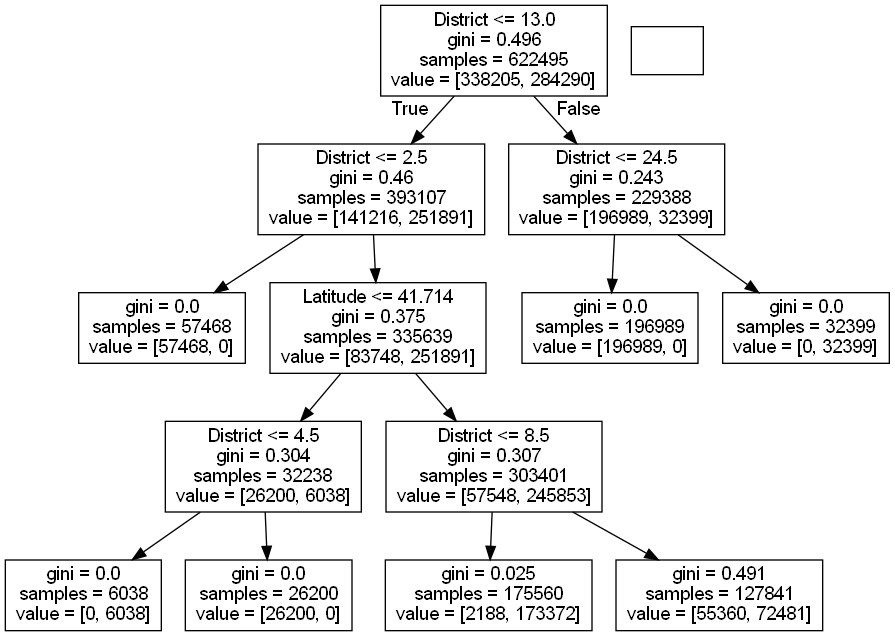

In [39]:
# I want to see the main features used for classification
from sklearn import tree
import pydotplus
from IPython.display import Image 
dot_data = tree.export_graphviz(dt_clf, out_file=None,feature_names=list(X))

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

In [40]:
# We can check the main features used for classification by checking the feature importance, the higher the value,
# more important the feature would be.
# We can sort the importance scores in descending order and take the top most.
importances=dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
# We have taken the top 5 feature 
print("The main features used for classification")
print(X.columns[indices[:5]])
print("Top main feature is",X.columns[indices[:1]][0])

Feature ranking:
The main features used for classification
Index(['District', 'Latitude', 'Longitude', 'Location Description',
       'Description'],
      dtype='object')
Top main feature is District


In [41]:
# Apply cross-validation (cross_val_score) to do 10-fold cross-validation to estimate the out-of-training accuracy of decision tree learnt above
dt_cv_accuracy = cross_val_score(dt_clf, X, y, cv=10).mean()
dt_cv_precision= cross_val_score(dt_clf, X, y, cv=10, scoring='precision').mean()
dt_cv_recall = cross_val_score(dt_clf, X, y, cv=10, scoring='recall').mean()
print("Cross Validation Accuracy DT:", dt_cv_accuracy)
print("Cross Validation Recall DT:", dt_cv_precision)
print("Cross Validation Precision DT:", dt_cv_recall)

Cross Validation Accuracy DT: 0.907925401037071
Cross Validation Recall DT: 0.8322828680034672
Cross Validation Precision DT: 1.0


Now, I will use Linear Classification to predict high crime rate district

In [42]:
# Use GaussianNB to learn a Naive Bayes classifier to predict high crime rate district
# Using GaussianNB
from sklearn.naive_bayes import GaussianNB
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.7)
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, y_train)

# Applying 10 fold cross validation
gaussian_accuracy = cross_val_score(gaussian_clf, X, y, cv=10).mean()
gaussian_precision= cross_val_score(gaussian_clf, X, y, cv=10, scoring='precision').mean()
gaussian_recall = cross_val_score(gaussian_clf, X, y, cv=10, scoring='recall').mean()
print("Accuracy for gaussian :", gaussian_accuracy)
print("Recall for gaussian:", gaussian_recall)
print("Precision for gaussian:", gaussian_precision)

Accuracy for gaussian : 0.6433962963744324
Recall for gaussian: 0.6619191670477329
Precision for gaussian: 0.5991824514030991


In [43]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gaussian_clf, X_test, y_test)
print(imps.importances_mean)
# Higher value shows greater importance. So we can see District is the most important feature and Location Description is the second important feature fo this model

[-0.00055797 -0.00128301 -0.00221045  0.00937515  0.09937617 -0.00325464
 -0.00048086]


We can see that the all scores are higher in case of Decision Trees. So in this case of High Crime Rate District Prediction, Decision Trees works much better than Gaussian NB.

Use LinearRegression to learn a linear model directly predicting the high crime rate district.

In [45]:
# Use 10-fold cross-validation to find the estimated meansquared- error (MSE) of the model
from sklearn.linear_model import LinearRegression
Y = crimes1['District Crime Rate']
linear_regression = LinearRegression()
mean_sq_err= cross_val_score(linear_regression,X, Y,scoring='neg_mean_squared_error',cv=10)
print("Estimated meansquared- error (MSE) of the model is",np.abs(mean_sq_err.mean()))

Estimated meansquared- error (MSE) of the model is 0.2132159454080944


In [46]:
# Find the MSE on the training set 
linear_regression.fit(X,Y)
yhat=linear_regression.predict(X)
from sklearn.metrics import mean_squared_error
MSE= mean_squared_error(y,yhat)
print("MSE on the training set is", MSE)

MSE on the training set is 0.21305075622714756


In [47]:
# Check the most predictive features by checking the coefficients, the larger the coeff, more predictive the feature.
list_coef = np.array(linear_regression.coef_)
print("Most Predictive Feature of a High Crime Rate is", X.columns[np.argmax(list_coef)])
print("Most Predictive Feature of a Low Crime Rate is", X.columns[np.argmin(list_coef)])

Most Predictive Feature of a High Crime Rate is Primary Type
Most Predictive Feature of a Low Crime Rate is Latitude


I think that the occurrence of crime and crime severity are also related to many other factors, such as unemployment, age, income, etc., but they are not included in my data set, so my prediction is not so comprehensive.
It's a pity that I didn't find a model that performed very well for predicting crime severity. For high crime district prediction, I have applied various models including: Decision Trees, Gaussian NB and Linear Regression. I also performed the 10 fold cross validation. The results are different. It can further be tested on many other models like Random Forests to identify the best that can be used to predict the crime rate.